In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize
from datetime import datetime, timedelta, date

import string, warnings
import matplotlib.pyplot as plt 
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
Punct_List = dict((ord(punct), None) for punct in string.punctuation + '¿¡')

def TxNormalize(text):
    
    return word_tokenize(text.lower().translate(Punct_List))

def respuesta(texto):
    Tokens_List.append(texto)
    TfidfVec = TfidfVectorizer(tokenizer = TxNormalize) 
    tfidf = TfidfVec.fit_transform(Tokens_List)
    Tokens_List.remove(texto)
    vals = cosine_similarity(tfidf[-1], tfidf)
    flat = vals.flatten()
    flat.sort()
    
    return Tokens_List[vals.argsort()[0][-2]]

# Datos Vacunación

In [3]:
url = 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Informe_Comunicacion_'
df=None
for i in range(100):
    try:
        df = (pd.read_excel(url + (datetime.now() - timedelta(days = + i)).strftime("%Y%m%d") + '.ods', engine="odf")
              .rename(columns = {'Dosis entregadas Pfizer (1)':'Dosis Pfizer'
                                 , 'Dosis entregadas (1)':'Dosis Pfizer'
                                 , 'Dosis entregadas AstraZeneca (1)': 'Dosis AstraZeneca'
                                 , 'Dosis entregadas Moderna (1)': 'Dosis Moderna'
                                 , 'Total Dosis entregadas (1)': 'Dosis'
                                 , 'Dosis administradas (2)': 'Puestas'
                                 , '% sobre entregadas': 'Usadas'
                                 , 'Unnamed: 0': 'Comunidad'
                                 , 'Nº Personas vacunadas(pauta completada)':'Pauta Completa'
                                 , 'Fecha de la última vacuna registrada (2)':'Fecha'
                            })
              .set_index('Fecha')
              .loc[lambda df: df.Comunidad != 'Totales']
              .append(df)
              .fillna(0))
        
    except:
        pass
    
df.tail()

,Comunidad,Dosis Pfizer,Puestas,Usadas,Dosis Moderna,Dosis,Pauta Completa,Dosis AstraZeneca
Fecha,,,,,,,,
2021-02-23,Murcia,121235,110564,0.720122,6600.0,153535.0,48528.0,25700.0
2021-02-23,Navarra,55725,53145,0.761117,2900.0,69825.0,20422.0,11200.0
2021-02-23,País Vasco,148410,117427,0.604639,7900.0,194210.0,45475.0,37900.0
2021-02-23,Ceuta,4320,5705,0.917203,400.0,6220.0,1087.0,1500.0
2021-02-23,Melilla,3150,4334,0.858218,400.0,5050.0,1266.0,1500.0


# Datos población

In [4]:
url = 'https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/2853.csv?nocab=1'

poblacion = pd.read_csv(url, error_bad_lines=False, sep=';', header=0)

poblacion = poblacion[(poblacion['Comunidades y Ciudades Autónomas'] != 'Total') 
                      & (poblacion['Periodo'] == 2020)].pivot(index = 'Comunidades y Ciudades Autónomas'
                                                             , columns = 'Sexo'
                                                             , values = 'Total')

Tokens_List = sent_tokenize(" ".join(review for review in df.Comunidad.unique() + '.'), 'spanish')
matriz = {}

for i in poblacion.index.values:
    matriz[i] = respuesta(i.replace('Balears','Baleares'))[:-1]
            
poblacion.index = poblacion.index.map(matriz)

poblacion.head()

Sexo,Hombres,Mujeres,Total
Comunidades y Ciudades Autónomas,,,
Andalucía,4.170.605,4.293.806,8.464.411
Aragón,656.056,673.335,1.329.391
Asturias,486.066,532.718,1.018.784
Baleares,584.298,587.245,1.171.543
Canarias,1.076.185,1.099.767,2.175.952


In [5]:
df = (df
       .reset_index()
       .set_index('Comunidad')
       .merge(poblacion, left_index=True, right_index=True)
       .reset_index()
       .set_index('Fecha')
       .drop(['Hombres','Mujeres'], axis = 1)
       .rename(columns = {'index': 'Comunidad'})
      )

df = (df
      .assign(Vacunados = np.array((df.Puestas - df['Pauta Completa']) / df.Total.str.replace('.','').astype(int) * 100))
      .assign(Inmunizados = np.array(df['Pauta Completa'] / df.Total.str.replace('.','').astype(int) * 100))
      .assign(Entregadas = np.array((-df['Dosis Pfizer'] - df['Dosis Moderna'] - df['Dosis AstraZeneca'] + df.Puestas)/ df.Total.str.replace('.','').astype(int) * 100))
      .loc[ :date.today().isoformat()]
     )

df.tail()

,Comunidad,Dosis Pfizer,Puestas,Usadas,Dosis Moderna,Dosis,Pauta Completa,Dosis AstraZeneca,Total,Vacunados,Inmunizados,Entregadas
Fecha,,,,,,,,,,,,
2021-02-17,País Vasco,127350,104091,0.672205,7900.0,154850.0,43642.0,19600.0,2.220.504,2.722310,1.965410,-2.285922
2021-02-18,País Vasco,127350,107391,0.693516,7900.0,154850.0,43919.0,19600.0,2.220.504,2.858450,1.977884,-2.137308
2021-02-21,País Vasco,127350,112681,0.727678,7900.0,154850.0,44558.0,19600.0,2.220.504,3.067907,2.006662,-1.899073
2021-02-22,País Vasco,127350,114568,0.739864,7900.0,154850.0,44902.0,19600.0,2.220.504,3.137396,2.022154,-1.814093
2021-02-23,País Vasco,148410,117427,0.604639,7900.0,194210.0,45475.0,37900.0,2.220.504,3.240345,2.047958,-3.457909


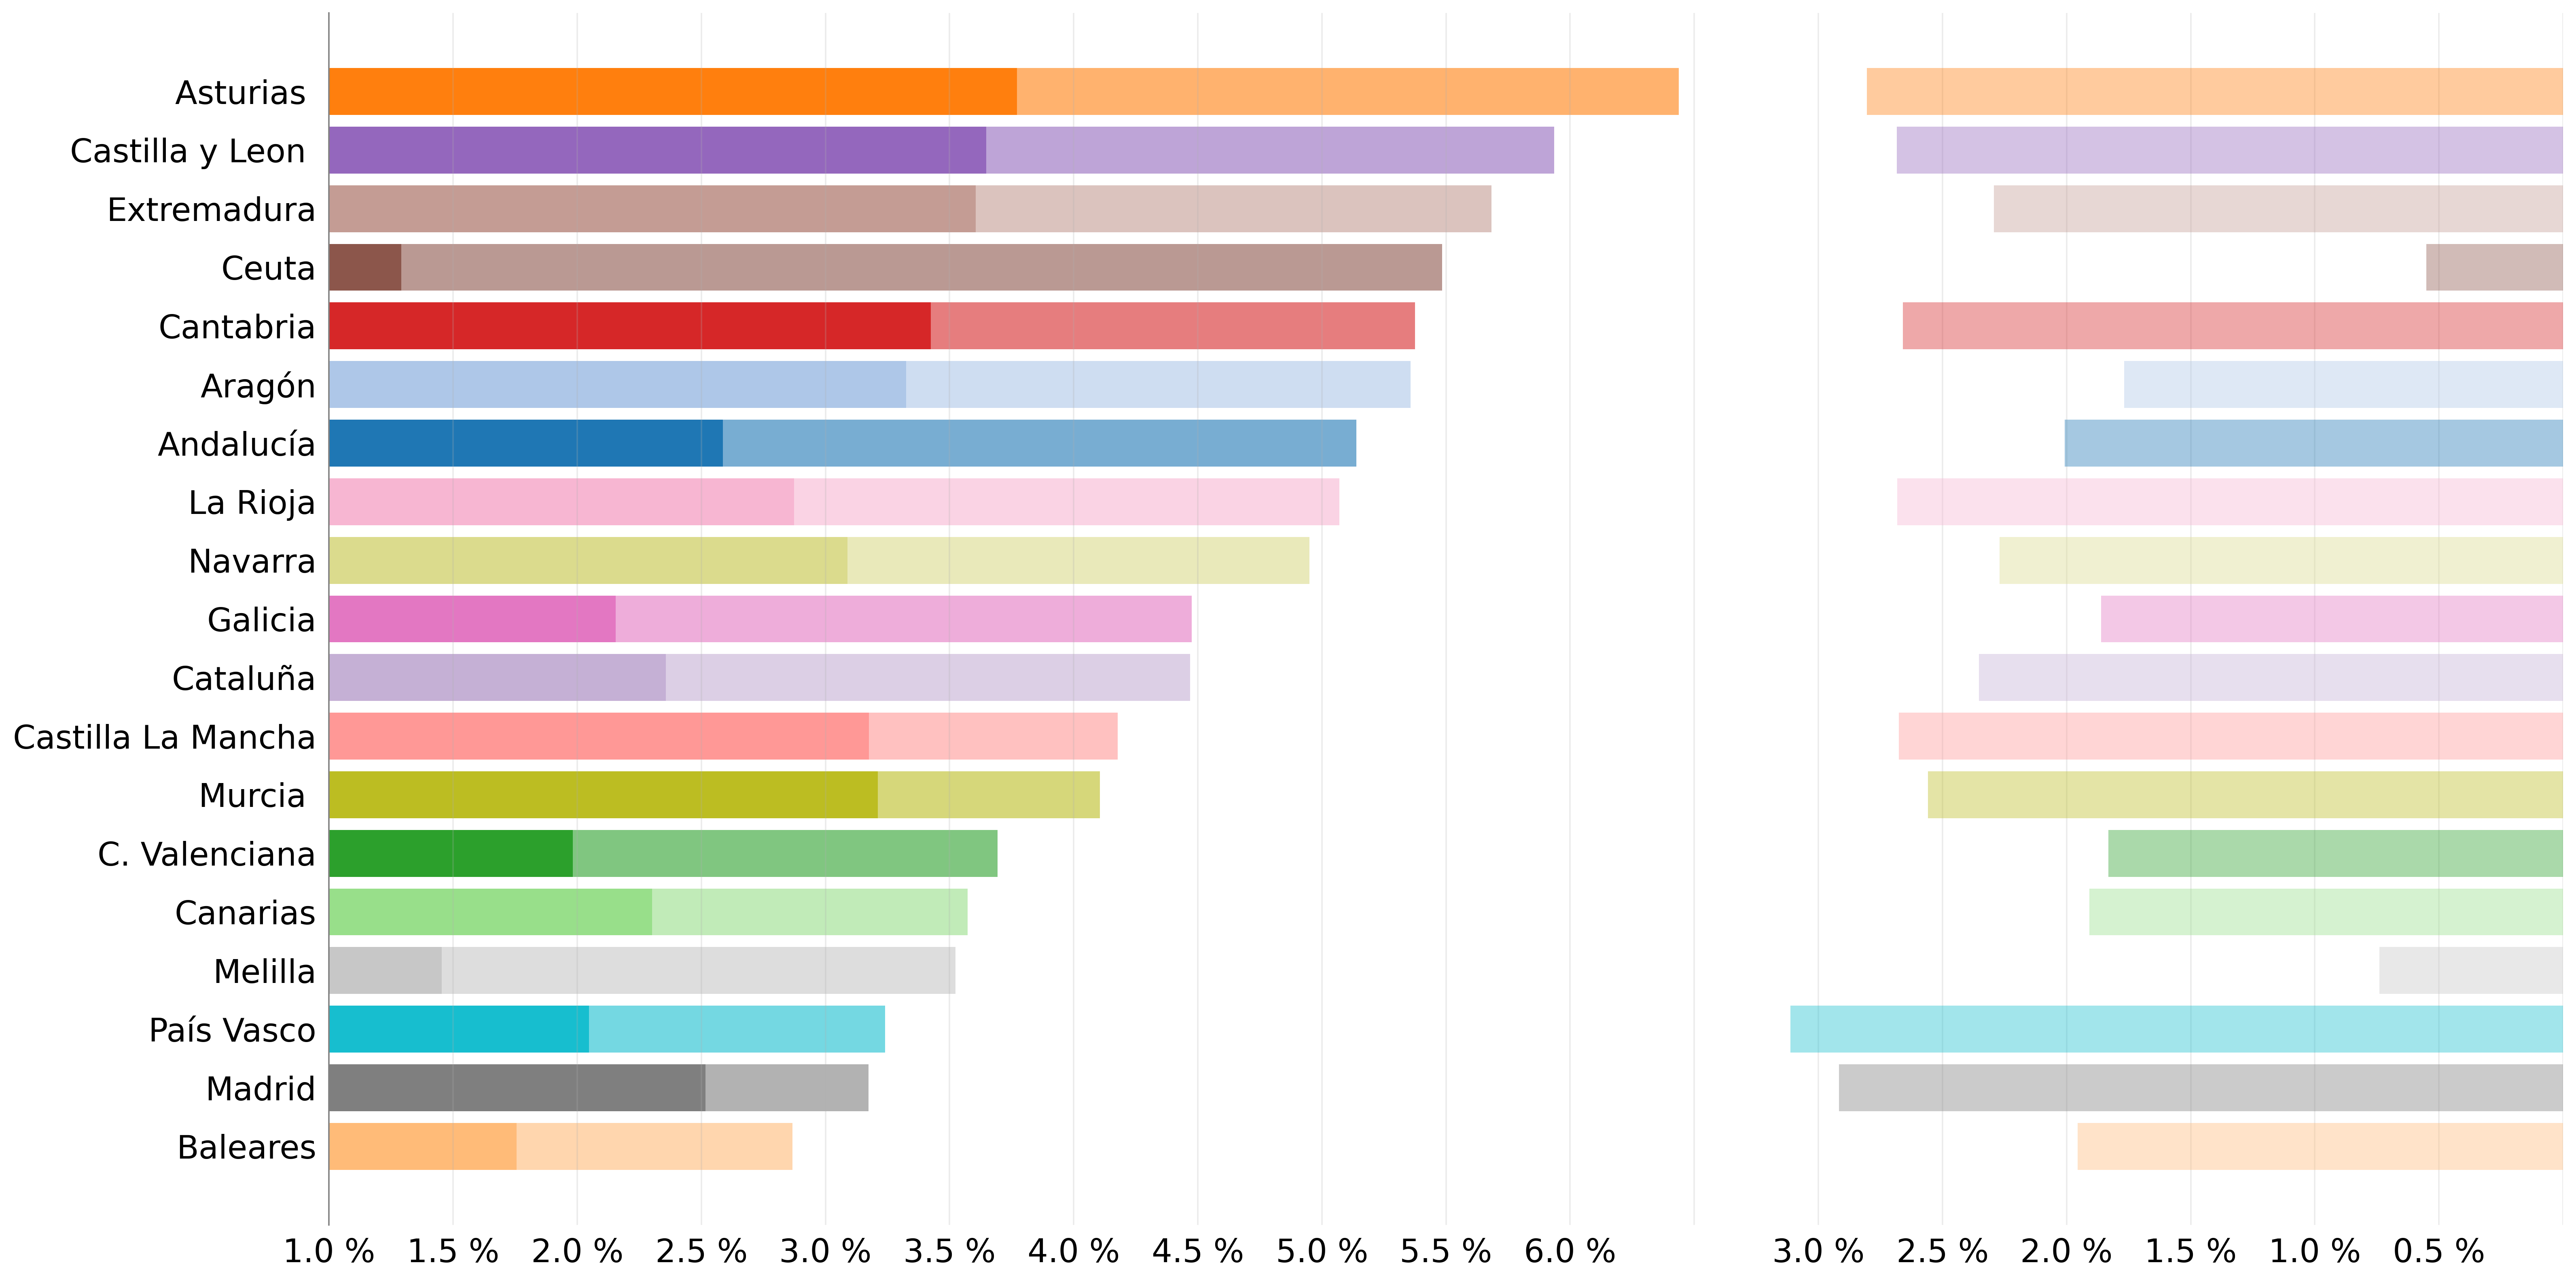

In [6]:
def nice_axes(ax, ax2, vals, a, b):
    [spine.set_visible(False) for spine in ax.spines.values()]
    ax.set_xlim(vals.min(), vals.max())
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_color('grey')
    ax.set_xticks(vals)
    ax.set_xticklabels(['{:3.1f} %'.format(x) if (x < a and x != 0)  else '{:3.1f} %'.format(vals.max() - x) if (vals.max() - x < - b and  vals.max() - x != 0) else None  for x in vals]
                       , fontsize = 18)
    
    ax.grid(axis='x', alpha=0.25)
    ax.yaxis.set_tick_params(labelsize=18)
    
    ax2.set_xticks(vals*-1)
    [spine.set_visible(False) for spine in ax2.spines.values()]
    ax2.set_xticklabels('')
    ax2.tick_params(left = False, top = False, bottom = False)
    ax.tick_params(left = False, bottom = False)
    
def pivot_table(df, val):
    
    return (df.reset_index()
            .drop_duplicates(['Fecha', 'Comunidad'], keep= 'last')
            .pivot(index = 'Fecha', columns='Comunidad', values= val)
            .fillna(method='ffill')
            .fillna(0))


colors = plt.cm.tab20(range(len(df.Comunidad.unique())))
i = df.index.sort_values(ascending = True).max().isoformat()

vals = np.linspace(start = int(df.loc[i].Inmunizados.min())
                   , stop = int(df.loc[i].Vacunados.max() - df.loc[i].Entregadas.min()) + 1
                   , num = int(df.loc[i].Vacunados.max() - df.loc[i].Entregadas.min() - int(df.loc[i].Inmunizados.min())) * 2 +3)

fig, ax = plt.subplots(nrows = 1
                             , ncols = 1
                             , figsize=(20,10), dpi = 320
                             , tight_layout=True)
ax2 = ax.twiny()

for AX, val, alpha in zip([ax, ax, ax2], ['Vacunados', 'Inmunizados','Entregadas'],[.6,1,.4]):
    
    datos = pivot_table(df, val)
    
    if val == 'Vacunados':
        orden = datos.loc[i].rank(method='first')
        tick = datos.loc[i].index
        
    AX.barh(y = orden
                , width = datos.loc[i].values
                , color = colors
                , tick_label= tick
                , alpha = alpha
               )
    
nice_axes(ax, ax2, vals, df.loc[i].Vacunados.max(), df.loc[i].Entregadas.min())  

In [20]:
def plot(df):
    fig, ax = plt.subplots(nrows = 1
                           , ncols = 1
                           , figsize = (20,len(aa) * .8)
                           , dpi = 960
                           , tight_layout = True)

    Grafico = df.plot(kind = 'barh'
                      , ax = ax
                      , stacked = True
                      , color = plt.cm.Set1(range(len(df.columns)))
                     )

    [spine.set_visible(False) for spine in Grafico.spines.values()]
    Grafico.spines['left'].set_visible(True)
    Grafico.spines['left'].set_color('grey')
    Grafico.set_ylabel('Semana', fontsize = 25, color = 'grey')
    Grafico.set_xlabel('')

    Grafico.legend(loc = 'upper center'
                       , bbox_to_anchor = (0.5, 1.2)
                       , ncol = len(df.columns)
                       , fancybox = False
                       , shadow = True
                       , fontsize = 20)


    Grafico.grid(axis='x', alpha=0.25)
    Grafico.yaxis.set_tick_params(labelsize=18)
    Grafico.xaxis.set_tick_params(labelsize=18)
    Grafico.set_yticklabels([x for x in df.index.strftime('%W')])
    Grafico.set_xticklabels(['' if x == 0 else str(int(x / 1000)) + ' k' for x in Grafico.get_xticks()])

    Grafico.tick_params(left = False, bottom = False)

In [8]:
aa = (df
      .resample('d')
      .agg({'Dosis Pfizer':'sum'
            , 'Dosis Moderna':'sum'
            , 'Dosis AstraZeneca':'sum'})
      .resample('w')
      .agg({'Dosis Pfizer':'last'
            , 'Dosis Moderna':'last'
            , 'Dosis AstraZeneca':'last'})
     .rename(columns = {'Dosis Pfizer':'Pfizer'
                        , 'Dosis AstraZeneca':'AstraZeneca'
                        , 'Dosis Moderna': 'Moderna'
                            }))

aa.Moderna = aa.Moderna - aa.Moderna.shift(1).fillna(0)
aa.Pfizer = aa.Pfizer - aa.Pfizer.shift(1).fillna(0)
aa.AstraZeneca = aa.AstraZeneca - aa.AstraZeneca.shift(1).fillna(0)

plot(aa)

In [9]:
aa = (df
      .groupby('Comunidad')
          .resample('w')
          .agg({'Puestas':'last'
                , 'Pauta Completa':'last'
               })
      .reset_index()
      .groupby('Fecha')
      .agg({'Puestas':'sum'
            , 'Pauta Completa':'sum'})
      .rename(columns = {'Puestas':'Primera dosis'
                        , 'Pauta Completa':'Segunda dosis'})
     )


aa['Primera dosis'] = aa['Primera dosis']  - aa['Primera dosis'] .shift(1).fillna(0)
aa['Segunda dosis'] = aa['Segunda dosis']  - aa['Segunda dosis'] .shift(1).fillna(0)

plot(aa)

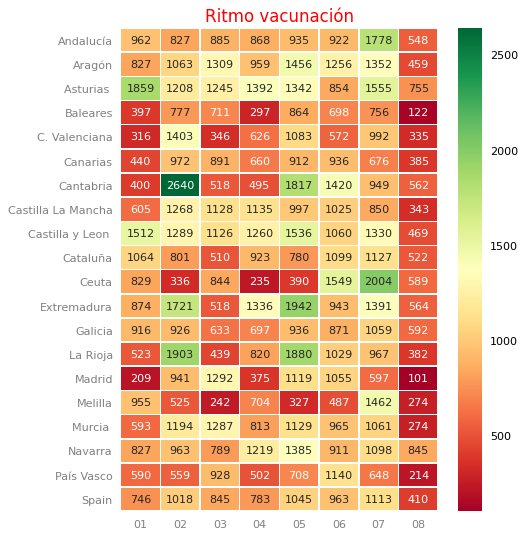

In [10]:
zz = None
for i in df.Comunidad.unique():
    tm = (df[df.Comunidad == i]
          .groupby('Comunidad')
          .resample('w')
          .agg({'Puestas':'last'
                , 'Total':'last'}))
    
    tm['puestas'] = tm.Puestas - tm.Puestas.shift(1).fillna(0)
    
    if zz is None:
        zz = tm
        
    else:
        zz = zz.append(tm)
        
zz['kpi'] = zz.puestas / zz.Total.str.replace('.','').astype('int64', copy=False) * 100000

tm = (df
      .groupby('Comunidad')
          .resample('w')
          .agg({'Puestas':'last'})
      .reset_index()
      .groupby('Fecha')
      .sum('Puestas')
     )
    
tm['puestas'] = tm.Puestas - tm.Puestas.shift(1).fillna(0)
tm['Comunidad'] = 'Spain'
tm['kpi'] = tm.puestas / poblacion.Total.str.replace('.','').astype('int64', copy=False).sum() * 100000
    
zz = (zz
      .reset_index(level = 0)
      .append(tm)
      .pivot(columns = 'Comunidad', values = 'kpi') 
     )

fig, ax = plt.subplots(1, 1
                       , figsize = (len(zz.transpose().columns) * .8, 8)
                       , dpi = 80
                      )

Grafico = sns.heatmap(zz.transpose()[zz.transpose().columns]
                          , ax = ax
                          , annot = True
                          , annot_kws = {"size": 10}
                          , xticklabels = zz.index.strftime("%W")
                          , fmt= '.0f' 
                          , linewidth = 0.5
                          , cbar = True
                          , cmap = plt.cm.get_cmap('RdYlGn'))



ax.tick_params(left = False, bottom = False, labelsize=10, labelcolor = 'grey')
Grafico.set_yticklabels(Grafico.get_yticklabels(), rotation = 0)
    
ax.set_title('Ritmo vacunación', fontsize = 15, color = 'Red')
ax.collections[0].colorbar.ax.tick_params(right = False, labelsize= 10)
ax.set_ylabel('')
ax.set_xlabel('')

fig.show()